In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [2]:
image_path = r"C:\Desktop\Sem 4\inverse-problems-regularization\images\toy.png"


img = plt.imread(image_path)
if img.ndim == 3:
    img = img.mean(axis=2)


x_true = img.astype(float)
x_true /= x_true.max()


print("Image shape:", x_true.shape)

Image shape: (16, 16)


In [3]:
def gaussian_kernel(size=9, sigma=2.0):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel


kernel = gaussian_kernel(size=9, sigma=2.0)

In [4]:
def A_op(x):
    return convolve2d(x, kernel, mode="same", boundary="symm")


def AT_op(x):
    flipped = np.flipud(np.fliplr(kernel))
    return convolve2d(x, flipped, mode="same", boundary="symm")

In [5]:
noise_std = 0.01
Ax = A_op(x_true)
eps = noise_std * np.random.randn(*Ax.shape)
y = Ax + eps


delta = np.linalg.norm(eps)
print("Noise level δ =", delta)

Noise level δ = 0.1685240759452131


In [6]:
n_iter_max = 50
alpha0 = 1e-1
q = 0.7


tau = 1.05

In [7]:
def solve_inner(rhs, alpha, n_inner=20, step=0.2):
    z = np.zeros_like(rhs)
    for _ in range(n_inner):
        grad = AT_op(A_op(z)) + alpha * z - rhs
        z -= step * grad
    return z


In [8]:
x = np.zeros_like(y)
residuals = []
errors = []
solutions = []


for n in range(n_iter_max):
    alpha_n = alpha0 * (q ** n)
    r = y - A_op(x)
    rhs = AT_op(r)


    update = solve_inner(rhs, alpha_n)
    x = x + update


    res_norm = np.linalg.norm(A_op(x) - y)
    residuals.append(res_norm)
    solutions.append(x.copy())


    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)


    print(f"Iter {n:02d} | alpha={alpha_n:.2e} | residual={res_norm:.3e}")


    if res_norm <= tau * delta:
        print("Morozov discrepancy satisfied at iteration", n)
        break

Iter 00 | alpha=1.00e-01 | residual=1.533e+00
Iter 01 | alpha=7.00e-02 | residual=3.366e-01
Iter 02 | alpha=4.90e-02 | residual=2.151e-01
Iter 03 | alpha=3.43e-02 | residual=1.848e-01
Iter 04 | alpha=2.40e-02 | residual=1.746e-01
Morozov discrepancy satisfied at iteration 4


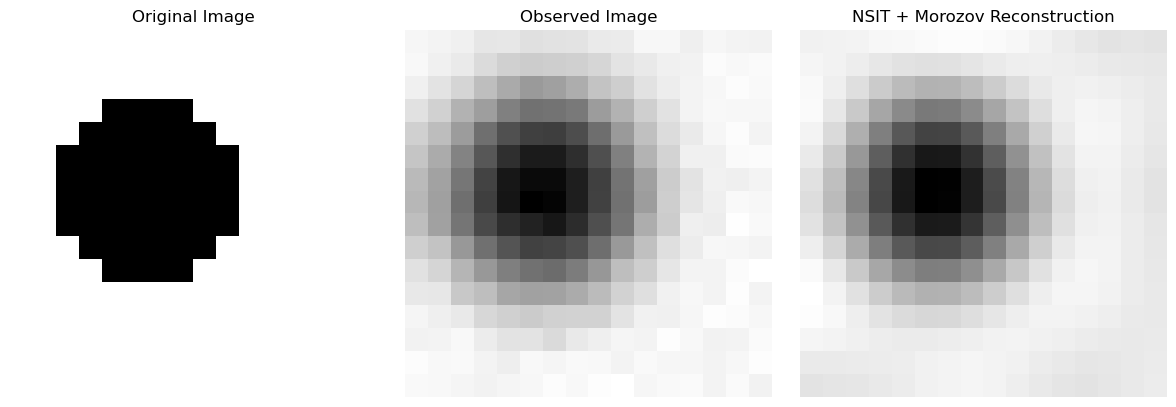

In [9]:
x_rec = x


plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(x_true, cmap="gray")
plt.title("Original Image")
plt.axis("off")


plt.subplot(1,3,2)
plt.imshow(y, cmap="gray")
plt.title("Observed Image")
plt.axis("off")


plt.subplot(1,3,3)
plt.imshow(x_rec, cmap="gray")
plt.title("NSIT + Morozov Reconstruction")
plt.axis("off")


plt.tight_layout()
plt.show()

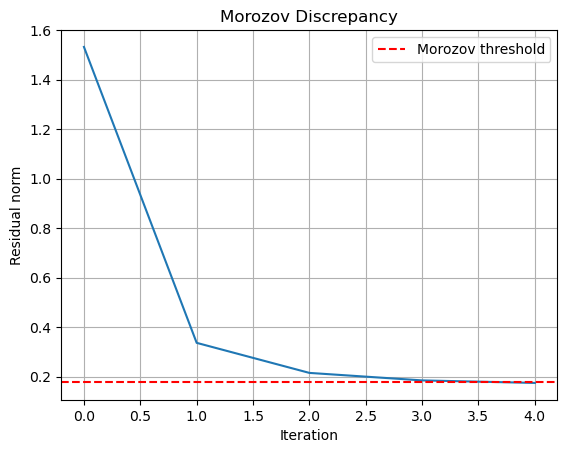

In [10]:
plt.figure()
plt.plot(residuals)
plt.axhline(tau * delta, color='r', linestyle='--', label='Morozov threshold')
plt.xlabel("Iteration")
plt.ylabel("Residual norm")
plt.title("Morozov Discrepancy")
plt.legend()
plt.grid(True)
plt.show()

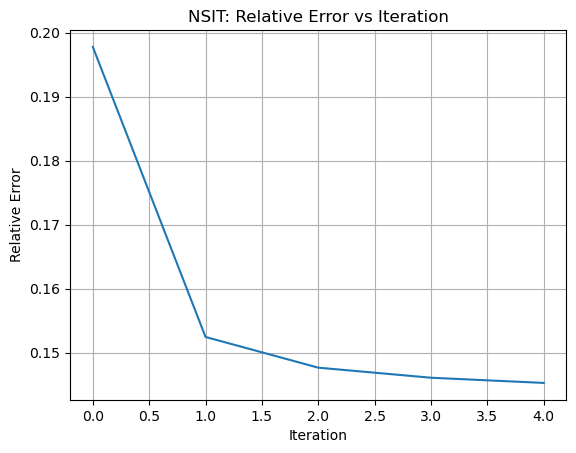

In [ ]:
plt.figure()
plt.plot(errors)
plt.xlabel("Iteration")
plt.ylabel("Relative Error")
plt.title("NSIT: Relative Error vs Iteration")
plt.grid(True)
plt.show()

print("="*50)
print("NSIT + MOROZOV RECONSTRUCTION ERROR ANALYSIS")
print("="*50)
final_error = np.linalg.norm(x_rec - x_true) / np.linalg.norm(x_true)
print(f"Final relative error: {final_error:.6f}")
print(f"Number of iterations: {len(errors)}")
print(f"Best error during iterations: {min(errors):.6f}")
print(f"Noise level δ: {delta:.6f}")
print(f"Final residual: {residuals[-1]:.6f}")
print(f"Morozov threshold (τ·δ): {tau * delta:.6f}")
print(f"Image size: {x_true.shape[0]}x{x_true.shape[1]}")
print(f"Kernel size: 9x9, Kernel/Image ratio: {9/x_true.shape[0]:.2f}")